In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.layers.experimental import preprocessing

LOAD DATA FROM AFPDB

In [2]:
import pathlib
font_csvs =  [str(p) for p in pathlib.Path('preproc_data/afpdb').glob("*.csv")]
train_csvs = font_csvs[0:40]+font_csvs[50:90]
test_csvs = font_csvs[40:50]+font_csvs[90:100]
afpdb_train_labels = np.array([0]*40*60+[1]*40*60)
afpdb_test_labels = np.array([0]*10*60+[1]*10*60)
print("AFPDB - Train labels size: ", afpdb_train_labels.size)
print("AFPDB - Test labels size:  ", afpdb_test_labels.size)

AFPDB - Train labels size:  4800
AFPDB - Test labels size:   1200


In [3]:
afpdb_train_data = np.array([])
for csv in train_csvs:
    data = pd.read_csv(csv, header=None)
    for c in range(data.shape[1]):
        row = np.array([np.array([data.iloc[:, c]])])
        if afpdb_train_data.shape[0] == 0:
            afpdb_train_data = row
        else:
            afpdb_train_data = np.vstack((afpdb_train_data, row))
afpdb_train_data = np.moveaxis(afpdb_train_data, 1, 2)
print("AFPDB - Train data shape: ", afpdb_train_data.shape)

AFPDB - Train data shape:  (4800, 900, 1)


In [4]:
afpdb_test_data = np.array([])
for csv in test_csvs:
    data = pd.read_csv(csv, header=None)
    for c in range(data.shape[1]):
        row = np.array([np.array([data.iloc[:, c]])])
        if afpdb_test_data.shape[0] == 0:
            afpdb_test_data = row
        else:
            afpdb_test_data = np.vstack((afpdb_test_data, row))
afpdb_test_data = np.moveaxis(afpdb_test_data, 1, 2)
print("AFPDB - Test data shape: ", afpdb_test_data.shape)

AFPDB - Test data shape:  (1200, 900, 1)


LOAD DATA FROM AFDB

In [5]:
afdb_csvs =  [str(p) for p in pathlib.Path('preproc_data/afdb').glob("*.csv")]
afdb_data = np.array([])
for csv in afdb_csvs:
    data = pd.read_csv(csv, header=None)
    for c in range(data.shape[1]):
        row = np.array([np.array([data.iloc[:, c]])])
        if afdb_data.shape[0] == 0:
            afdb_data = row
        else:
            afdb_data = np.vstack((afdb_data, row))
afdb_data = np.moveaxis(afdb_data, 1, 2)
print("AFDB data shape: ", afdb_data.shape)

AFDB data shape:  (5253, 900, 1)


In [6]:
import math
TEST_PROP = 0.8
index_split = math.ceil(afdb_data.shape[0] * TEST_PROP)
afdb_train = afdb_data[:index_split,:,:]
afdb_test = afdb_data[index_split:,:,:]
print("AFDB - Train data shape: ", afdb_train.shape)
print("AFDB - Test data shape:  ", afdb_test.shape)

AFDB - Train data shape:  (4203, 900, 1)
AFDB - Test data shape:   (1050, 900, 1)


In [7]:
afdb_train_labels = np.array([1]*afdb_train.shape[0])
afdb_test_labels = np.array([1]*afdb_test.shape[0])
train_labels = np.concatenate((afpdb_train_labels, afdb_train_labels))
test_labels = np.concatenate((afpdb_test_labels, afdb_test_labels))
print("Total - Train labels size: ", train_labels.size)
print("Total - Test labels size:  ", test_labels.size)

Total - Train labels size:  9003
Total - Test labels size:   2250


In [8]:
train_data = np.concatenate((afpdb_train_data, afdb_train))
test_data = np.concatenate((afpdb_test_data, afdb_test))
print("Total - Train data shape: ", train_data.shape)
print("Total - Test data shape: ", test_data.shape)

Total - Train data shape:  (9003, 900, 1)
Total - Test data shape:  (2250, 900, 1)


LOAD DATA FROM NSRDB

In [9]:
nsrdb_csvs =  [str(p) for p in pathlib.Path('preproc_data/nsrdb').glob("*.csv")]
nsrdb_data = np.array([])
for csv in nsrdb_csvs:
    data = pd.read_csv(csv, header=None)
    for c in range(data.shape[1]):
        row = np.array([np.array([data.iloc[:, c]])])
        if nsrdb_data.shape[0] == 0:
            nsrdb_data = row
        else:
            nsrdb_data = np.vstack((nsrdb_data, row))
nsrdb_data = np.moveaxis(nsrdb_data, 1, 2)
print("NSRDB data shape: ", nsrdb_data.shape)

NSRDB data shape:  (6840, 900, 1)


In [10]:
index_split = math.ceil(nsrdb_data.shape[0] * TEST_PROP)
nsrdb_train = nsrdb_data[:index_split,:,:]
nsrdb_test = nsrdb_data[index_split:,:,:]
print("NSRDB - Train data shape: ", nsrdb_train.shape)
print("NSRDB - Test data shape:  ", nsrdb_test.shape)

NSRDB - Train data shape:  (5472, 900, 1)
NSRDB - Test data shape:   (1368, 900, 1)


In [11]:
nsrdb_train_labels = np.array([0]*nsrdb_train.shape[0])
nsrdb_test_labels = np.array([0]*nsrdb_test.shape[0])
train_labels2 = np.concatenate((train_labels, nsrdb_train_labels))
test_labels2 = np.concatenate((test_labels, nsrdb_test_labels))
print("Total - Train labels size: ", train_labels2.size)
print("Total - Test labels size:  ", test_labels2.size)

Total - Train labels size:  14475
Total - Test labels size:   3618


In [12]:
train_data2 = np.concatenate((train_data, nsrdb_train))
test_data2 = np.concatenate((test_data, nsrdb_test))
print("Total - Train data shape: ", train_data2.shape)
print("Total - Test data shape:  ", test_data2.shape)

Total - Train data shape:  (14475, 900, 1)
Total - Test data shape:   (3618, 900, 1)


BUILD DATASET OBJECTS

In [68]:
not_train_labels2 = np.logical_not(train_labels2).astype(int)
not_test_labels2 = np.logical_not(test_labels2).astype(int)
train_labels_def = np.array([not_train_labels2, train_labels2])
test_labels_def = np.array([not_test_labels2, test_labels2])
train_labels_def = np.swapaxes(train_labels_def, 0, 1)
test_labels_def = np.swapaxes(test_labels_def, 0, 1)
print("Train labels shape: ", train_labels_def.shape)
print("Test labels shape:  ", test_labels_def.shape)

Train labels shape:  (14475, 2)
Test labels shape:   (3618, 2)


In [73]:
train = tf.data.Dataset.from_tensor_slices((train_data2, train_labels_def))
test = tf.data.Dataset.from_tensor_slices((test_data2, test_labels_def))

train = train.shuffle(len(train)).batch(2)
test = test.batch(1)

for d, l in train.take(1):
    print ("Data batch size:   ", d.shape)
    print ("Labels batch size: ", l.shape)

Data batch size:    (2, 900, 1)
Labels batch size:  (2, 2)


In [74]:
model = models.Sequential()
model.add(layers.BatchNormalization(input_shape=(900,1)))
model.add(layers.Conv1D(16,8))

model.add(layers.MaxPool1D(strides=2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(32,4))
model.add(layers.Conv1D(32,4))
model.add(layers.MaxPool1D(strides=2))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(16, activation='relu'))

model.add(layers.MaxPool1D(strides=2))
model.add(layers.Dropout(0.25))
model.add(layers.Conv1D(32,2))
model.add(layers.Conv1D(32,2))
model.add(layers.MaxPool1D(strides=2))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(8, activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(2))

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_15 (Batc (None, 900, 1)            4         
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 893, 16)           144       
_________________________________________________________________
max_pooling1d_60 (MaxPooling (None, 446, 16)           0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 446, 16)           0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 443, 32)           2080      
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 440, 32)           4128      
_________________________________________________________________
max_pooling1d_61 (MaxPooling (None, 220, 32)         

In [75]:
class CategoricalTruePositives(tf.keras.metrics.Metric):
    def __init__(self, name="TP", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        y_true = tf.reshape(tf.argmax(y_true, axis=1), shape=(-1, 1))
        values = (tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")) & (tf.cast(y_true, "int32") > 0)
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)
        
class CategoricalTrueNegatives(tf.keras.metrics.Metric):
    def __init__(self, name="TN", **kwargs):
        super(CategoricalTrueNegatives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        y_true = tf.reshape(tf.argmax(y_true, axis=1), shape=(-1, 1))
        values = (tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")) & (tf.cast(y_true, "int32") < 1)
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)
        
class CategoricalFalsePositives(tf.keras.metrics.Metric):
    def __init__(self, name="FP", **kwargs):
        super(CategoricalFalsePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        y_true = tf.reshape(tf.argmax(y_true, axis=1), shape=(-1, 1))
        values = (tf.cast(y_true, "int32") != tf.cast(y_pred, "int32")) & (tf.cast(y_true, "int32") < 1)
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)
        
class CategoricalFalseNegatives(tf.keras.metrics.Metric):
    def __init__(self, name="FN", **kwargs):
        super(CategoricalFalseNegatives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        y_true = tf.reshape(tf.argmax(y_true, axis=1), shape=(-1, 1))
        values = (tf.cast(y_true, "int32") != tf.cast(y_pred, "int32")) & (tf.cast(y_true, "int32") > 0)
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)

In [76]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
             loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             metrics=['accuracy', CategoricalTruePositives(), CategoricalTrueNegatives(),
                     CategoricalFalsePositives(), CategoricalFalseNegatives()])

history = model.fit(train, epochs=10,
                       validation_data=(test))

Epoch 1/10
7238/7238 [==============================] - 69s 9ms/step - loss: 0.4207 - accuracy: 0.7750 - TP: 4959.0000 - TN: 6259.0000 - FP: 1613.0000 - FN: 1644.0000 - val_loss: 0.5363 - val_accuracy: 0.8181 - val_TP: 1589.0000 - val_TN: 1371.0000 - val_FP: 597.0000 - val_FN: 61.0000
Epoch 2/10
7238/7238 [==============================] - 68s 9ms/step - loss: 0.2752 - accuracy: 0.8791 - TP: 6273.0000 - TN: 6452.0000 - FP: 1420.0000 - FN: 330.0000 - val_loss: 0.6038 - val_accuracy: 0.7557 - val_TP: 1366.0000 - val_TN: 1368.0000 - val_FP: 600.0000 - val_FN: 284.0000
Epoch 3/10
7238/7238 [==============================] - 68s 9ms/step - loss: 0.2248 - accuracy: 0.9055 - TP: 6275.0000 - TN: 6832.0000 - FP: 1040.0000 - FN: 328.0000 - val_loss: 0.9424 - val_accuracy: 0.7648 - val_TP: 1400.0000 - val_TN: 1367.0000 - val_FP: 601.0000 - val_FN: 250.0000
Epoch 4/10
7238/7238 [==============================] - 70s 10ms/step - loss: 0.1871 - accuracy: 0.9323 - TP: 6314.0000 - TN: 7181.0000 - FP: 

In [82]:
test_afpdb_nr = model.predict(test.take(600))
test_afpdb_af = model.predict(test.take(1200))
test_afdb_af = model.predict(test.take(2250))
test_nsrdb_nr = model.predict(test.take(3618))

test_afpdb_nr = np.argmax(test_afpdb_nr, axis=1)
test_afpdb_af = np.argmax(test_afpdb_af, axis=1)
test_afdb_af = np.argmax(test_afdb_af, axis=1)
test_nsrdb_nr = np.argmax(test_nsrdb_nr, axis=1)

a, b = np.unique(test_afpdb_nr, return_counts=True)
print("Test afpdb NR: ", dict(zip(a, b)))
c, d = np.unique(test_afpdb_af, return_counts=True)
print("Test afpdb AF: ", dict(zip(c, d)))
unique, counts = np.unique(test_afdb_af, return_counts=True)
print("Test afdb  AF: ", dict(zip(unique, counts)))
unique, counts = np.unique(test_nsrdb_nr, return_counts=True)
print("Test nsrdb NR: ", dict(zip(unique, counts)))

Test afpdb NR:  {1: 600}
Test afpdb AF:  {0: 280, 1: 920}
Test afdb  AF:  {0: 311, 1: 1939}
Test nsrdb NR:  {0: 1679, 1: 1939}


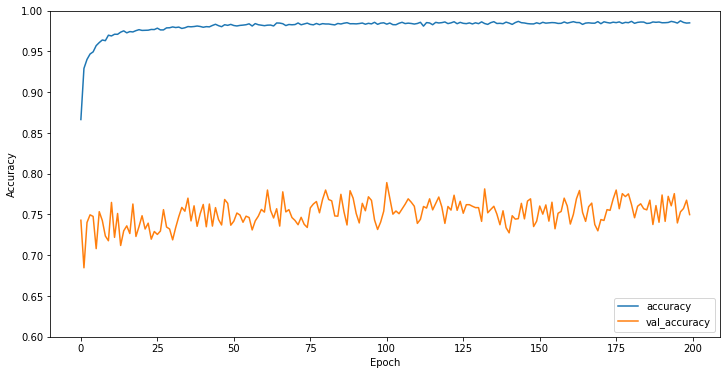

In [19]:
plt.rcParams['figure.figsize'] = [12, 6]
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.6, 1])
plt.legend(loc='lower right')

In [20]:
test_loss, test_acc = model.evaluate(test, verbose=2)

227/227 - 1s - loss: 3.3507 - accuracy: 0.7499
